In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, add, Flatten, Dense, DepthwiseConv2D


def PEPXModel(input_tensor, filters, name):
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'FP')(input_tensor)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Expansion')(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same', name=name + 'DWConv3_3')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'SP')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Extension')(x)
    return x


def keras_model_build(input_size=(240,240, 3)):
    # input
    input = Input(shape=input_size, name='input')
    x = Conv2D(input_shape=input_size, filters=56, kernel_size=(7, 7), activation='relu', padding='same',
               strides=(1, 1))(input)
    x = MaxPool2D(pool_size=(2, 2))(x)
    # _Conv1x1
    x =Conv2D(filters=56, kernel_size=(1,1), activation= 'relu' ,name = "conv1x156") (x) 
    # pepx1 
    pepx_11 = PEPXModel(x, 56, "pepx1.1")
    pexp_12 = PEPXModel(add([x,pepx_11]),56, "pepx1.2")
    pexp_13 = PEPXModel(add([x,pepx_11,pexp_12]),56, "pepx1.3")
    #conv1x1
    x = Conv2D(112,kernel_size=(1,1),strides=2, activation = "relu", name = "conv1x1112") (add([x,pepx_11,pexp_12,pexp_13]))
    #pepx2
    pepx_21 = PEPXModel(x, 112, "pepx21")
    pepx_22 = PEPXModel(add([x,pepx_21]), 112, "pepx22")
    pepx_23 = PEPXModel(add([x,pepx_21,pepx_22]), 112, "pepx23")
    pepx_24 = PEPXModel(add([x,pepx_21,pepx_22,pepx_23]), 112, "pepx24")
    #conv1x1 
    x = Conv2D(224,kernel_size=(1,1),strides=2, activation = "relu", name = "conv1x140") (add([x,pepx_21,pepx_22,pepx_23,pepx_24]))
    #pepx3
    pepx_31 = PEPXModel(x,224,'pepx31')
    pepx_32 = PEPXModel(add([x,pepx_31]),224,'pepx32')
    pepx_33 = PEPXModel(add([x,pepx_31,pepx_32]),224,'pepx33')
    pepx_34 = PEPXModel(add([x,pepx_31,pepx_32,pepx_33]),224,'pepx34')
    pepx_35 = PEPXModel(add([x,pepx_31,pepx_32,pepx_33,pepx_34]),224,'pepx35')
    pepx_36 = PEPXModel(add([x,pepx_31,pepx_32,pepx_33,pepx_34,pepx_35]),224,'pepx36')
    #conv1x1 
    x = Conv2D(424,kernel_size=(1,1),strides=2, activation = "relu", name = "conv1x1424") (add([x,pepx_31,pepx_32,pepx_33,pepx_34, pepx_35,pepx_36]))
    #pepx4
    pepx_41 = PEPXModel(x,424,'pepx41')
    pepx_42 = PEPXModel(add([x,pepx_41]),424,'pepx42')
    pepx_43 = PEPXModel(add([x,pepx_41,pepx_42]),424,'pepx43')
    # FC
    fla = Flatten()(add([x,pepx_41,pepx_42,pepx_43]))
    d1 = Dense(256, activation='relu')(fla)
    d1 = Dense(128, activation='relu')(d1)
    output = Dense(3, activation='softmax')(d1)
    return keras.models.Model(input, output)

model = keras_model_build()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 240, 240, 56  8288        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 120, 120, 56  0          ['conv2d_2[0][0]']               
                                )                                                           

In [ ]:
import numpy as np
import tensorflow as tf


src = "drive/MyDrive/"
x = np.load(src+"Fold-1/data-train-x-1.npy")
y = np.load(src+"Fold-1/data-train-y-1.npy")
model = keras_model_build()
# model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x, y, batch_size=32, epochs=10)
model.save("drive/MyDrive/modelcnn/modelfold.h5")



In [3]:
import numpy as np
import tensorflow as tf

src = "drive/MyDrive/"
xt = np.load(src+"Fold-1/data-test-x-1.npy")
yt = np.load(src+"Fold-1/data-test-y-1.npy")


In [4]:
import matplotlib.pyplot as plt
def conf_mat(conf_arr, title):
    norm_conf = []
    for i in conf_arr:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize=(8,8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.set_title(title)
    ax.set_xlabel("Prediksi Class")
    ax.set_ylabel("Target Class")
    res = ax.imshow(np.array(norm_conf), cmap="Paired", 
                    interpolation='nearest')

    width, height = conf_arr.shape
    textcolors = ["w", "k"]
    for x in range(width):
        for y in range(height):
            ax.text(y, x, str(conf_arr[x][y]),
                    ha="center", va="center",
                    color=textcolors[0.2 < norm_conf[x][y] < 0.9],
                    fontsize=13,
                    weight='bold')

In [5]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import Sequential, Model, load_model
import time 
mod_path2 = "drive/MyDrive/modelcnn/"

LABEL_NAMES = ["COVID","Normal","Pneumonia"]

target_test = np.argmax(yt,axis=1)

mod = load_model(mod_path2+"modelfold1.h5")
awal = time.time()
model = mod.predict(xt)
y_pred = np.argmax(model, axis=1)

print("Hasil K-Fold-1")

cls_report = classification_report(target_test, y_pred, target_names=LABEL_NAMES)

print (cls_report)

acc_score = accuracy_score(target_test, y_pred)
print (acc_score)

cm = confusion_matrix(target_test, y_pred)



print("F1-skor Keseluruhan")

precision = precision_score(target_test, y_pred, average='macro')
recall = recall_score(target_test, y_pred, average='macro')
f1_score = 2 * precision * recall / (precision + recall)
ahir = time.time()
waktu_testing = ahir-awal 
print("waktu testing =",waktu_testing,"detik")
print("Precision = ", precision)
print("Recall = ", recall)
print("F1 Score = ", f1_score)

Hasil K-Fold-1
              precision    recall  f1-score   support

       COVID       0.91      0.99      0.95       300
      Normal       1.00      0.89      0.94       300
   Pneumonia       0.97      1.00      0.99       269

    accuracy                           0.96       869
   macro avg       0.96      0.96      0.96       869
weighted avg       0.96      0.96      0.96       869

0.9585730724971231
F1-skor Keseluruhan
waktu testing = 983.3808314800262 detik
Precision =  0.9618935419815654
Recall =  0.96
F1 Score =  0.9609458381864526


In [6]:
import matplotlib.pyplot as plt
jumlah = 0
for image, prediction, label in zip(xt, y_pred, target_test ):
  if prediction != label:
    print('has been classified as ',LABEL_NAMES[prediction], 'and should be ', LABEL_NAMES[label])
    jumlah+=1
print(jumlah) 
    

has been classified as  Pneumonia and should be  COVID
has been classified as  Pneumonia and should be  COVID
has been classified as  Pneumonia and should be  COVID
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  Pneumonia and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  COVID and should be  Normal
has been classified as  Pneumonia and should be  No

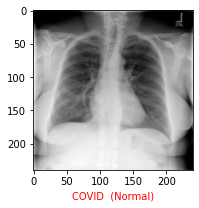

In [40]:
import matplotlib.pyplot as plt
jumlah = 0
plt.figure(figsize=(20, 20))
plt.subplot(5, 6, 15)
for image, prediction, label in zip(xt, y_pred, target_test ):
  if prediction != label:
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel("{}  ({})".format(LABEL_NAMES[prediction],
                                LABEL_NAMES[label]),
                                color='red')

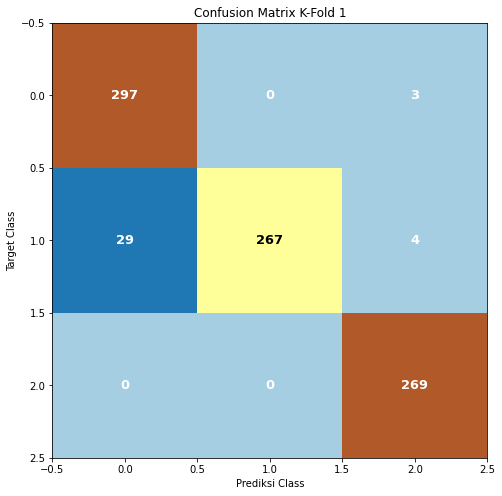

In [ ]:
conf_mat(cm, "Confusion Matrix K-Fold 1" )

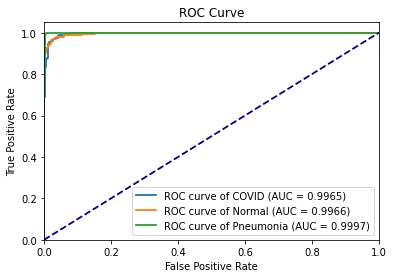

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

def show_roc_curve(y_test_cat, y_pred_prob, target, title):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:,i], y_pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  linewidth = 1.8
  plt.figure()
  plt.title(title)
  for i in range(3):
      plt.plot(fpr[i], tpr[i], lw=linewidth, label='ROC curve of %s (AUC = %0.4f)' % (LABEL_NAMES[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

show_roc_curve(yt, model, target_test, 'ROC Curve')

0.996557025587921

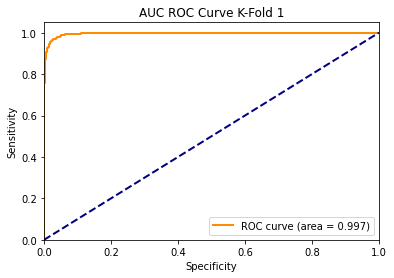

In [ ]:
def create_auc_roc(y_test_cat, y_pred_cat, title):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], model[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_cat.ravel(), model.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
            lw=lw, label='ROC curve (area = %0.3f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title(title)
    plt.legend(loc="lower right")
    
    return roc_auc["micro"]
create_auc_roc(yt, model, "AUC ROC Curve K-Fold 1" )

In [ ]:
!python --version

Python 3.7.13
